In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
from pathlib import Path
import sys
import torch

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [7]:
def process_data(file, y_labels, x_labels, test=False):
    # Read data
    data = h5py.File(file, "r")
    df = pd.DataFrame(columns = x_labels)

    for i in range(len(x_labels)):
        df[x_labels[i]] = np.array(data["data"][:, i]).flatten()
   
    if ("x1" in x_labels):
        df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    elif ("r_x" in x_labels):
        df = polar_to_cartesian_df(df, "x1", "x2", "r_x", "a_x")

    df["Confidence"] = data["confidence"]
    
    # Get truth label values (annoying because text is not read as text, should fix)
    # Is fixed, just update
    if (test == False):
        df["Truth_value"] = data["truth"]
        df["Truth"] = y_labels[0]
        blue = 1.0
        df_copy = df.copy()
        mask = df_copy["Truth_value"] == blue
        df.loc[mask, "Truth"] = y_labels[1]
    
    # Get estimated probabilities
    for i in range(len(y_labels)):
        df[y_labels[i]] = data["probabilities"][:,i]
        df[f"P({y_labels[i]}|x)"] = data["probabilities"][:,i]

    # Get inferred color
    df["Inferred_color"] = df[[y_labels[0], y_labels[1]]].idxmax(axis=1)

    # Get 25-75% error bars
    for i in range(len(y_labels)):
        df[f"quantile25_{y_labels[i]}"] = data["quantiles"][:, 1, i]
        df[f"quantile75_{y_labels[i]}"] = data["quantiles"][:, 2, i]
        df[f"Error_{y_labels[i]}"] = df[f"quantile75_{y_labels[i]}"] - df[f"quantile25_{y_labels[i]}"]
    
    return df

In [8]:
def plot_results(df, weight_key, ax, suptitle, grid=False):
    ax.set_title(suptitle)
    #sn.set_theme(style="whitegrid")

    cmap = red_blue_cmap()
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df[weight_key], 
                bins = 100,
                norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=weight_key, 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                    size="Error_blue", size_norm = (0.1, 0.3), sizes=(10, 200),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.set_aspect('equal', adjustable='box')

    return ax

In [9]:
# Setup

#MCMC constants
n_samples = 1200
#n_cal = [250, 1000, 2000, 3000, 4000, 5000]
n_cal = [250, 500, 750, 1000, 1250, 1500, 1750, 2000]
n_chains = 10
n_plots = len(n_cal)

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Data labels
y_labels = ["red", "blue"]
x_labels = ["x1", "x2"]

# Read files
folderpath = "calibrate"
train_n = 5000
calfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}_predicted_SequentialNet_10ensembles_ndata-{train_n}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_200_nr1MC_200"
gridfile = f"grid_{tag}_predicted_SequentialNet_10ensembles_ndata-{train_n}"
trainfile = f"train_n_50000_{tag}"

if polar:
    analysis_folders = [f"{calfile}_predicted_SequentialNet_10ensembles_ndata-{train_n}/nsamples-1200_nchains-{n_chains}_ncal-{n_cal[i]}_POLAR" for i in range(n_plots)]
else:
    analysis_folders = [f"{calfile}_predicted_SequentialNet_10ensembles_ndata-{train_n}/nsamples-1200_nchains-{n_chains}_ncal-{n_cal[i]}" for i in range(n_plots)]
gridfiles = [f"{folderpath}/{folder}/{gridfile}_inferred.h5" for folder in analysis_folders]
testfiles = [f"{folderpath}/{folder}/{testfile}_inferred.h5" for folder in analysis_folders]
cal_data = pd.read_csv(f"../DNN/predictions/{trainfile}/{calfile}_predicted_SequentialNet_10ensembles_ndata-{train_n}.csv")
test_data = pd.read_csv(f"../DNN/predictions/{trainfile}/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

test_dfs = [0]*n_plots
grid_dfs = [0]*n_plots

for i in range(n_plots):
    df_test = process_data(testfiles[i], y_labels, x_labels)
    df_grid = process_data(gridfiles[i], y_labels, x_labels, test=True)
    test_dfs[i] = df_test
    grid_dfs[i] = df_grid

# Key to use for plotting
weight_key = f"P({y_labels[1]}|x)"

/tmp/ipykernel_9835/4191905136.py:33: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df["Inferred_color"] = df[[y_labels[0], y_labels[1]]].idxmax(axis=1)
/tmp/ipykernel_9835/4191905136.py:33: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df["Inferred_color"] = df[[y_labels[0], y_labels[1]]].idxmax(axis=1)
/tmp/ipykernel_9835/4191905136.py:33: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df["Inferred_color"] = df[[y_labels[0], y_labels[1]]].idxmax(axis=1)
/tmp/ipykernel_9835/4191905136.py:33: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  d

Text(0.5, 0.98, 'Number of datapoints: 2000')

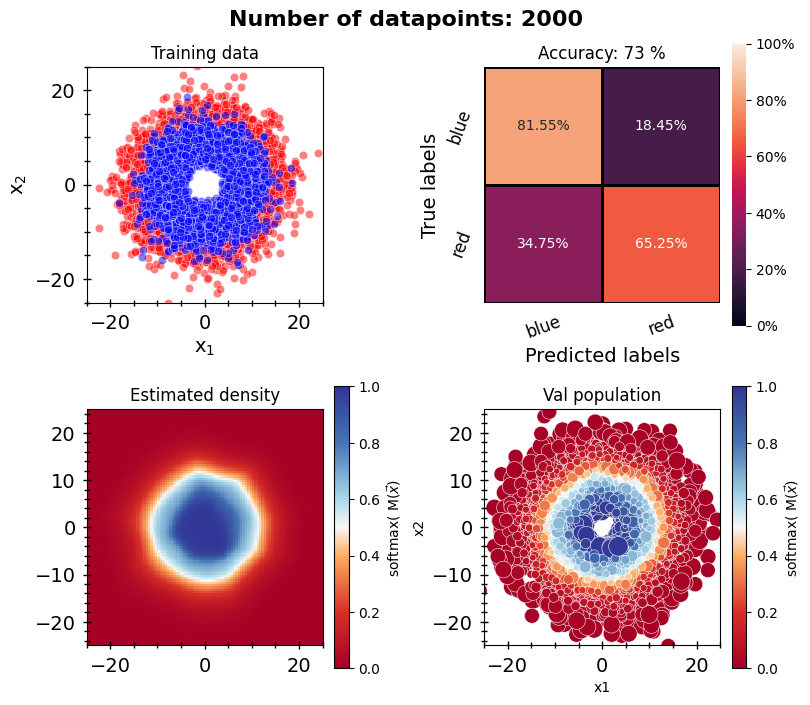

In [10]:

# Plot animation

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")

#plot data
axs[0][0] = plot_data(cal_data[0:train_n], axs[0][0], "Training data")
axs[0][1] = plot_conf_matrix(test_dfs[0], "Truth", "Inferred_color", ["blue", "red"], axs[0][1])
axs[1][0] = plot_results(grid_dfs[0], "Confidence", axs[1][0], "Estimated density", grid=True)
axs[1][1] = plot_results(test_dfs[0], "Confidence", axs[1][1], "Val population")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

fig.suptitle(f"Number of datapoints: {n_cal[i]}", size=16, fontweight="bold")

#plt.show()
    

In [11]:
df_test

,x1,x2,r_x,a_x,Confidence,Truth_value,Truth,red,P(red|x),blue,P(blue|x),Inferred_color,quantile25_red,quantile75_red,Error_red,quantile25_blue,quantile75_blue,Error_blue
0,4.637181,11.350187,12.260921,1.182936,0.354201,0.0,red,0.629173,0.629173,0.370827,0.370827,red,0.592290,0.675470,0.083181,0.324530,0.407710,0.083181
1,10.042744,10.382106,14.444543,0.802012,0.246766,0.0,red,0.803942,0.803942,0.196058,0.196058,red,0.768040,0.845464,0.077424,0.154536,0.231960,0.077424
2,-5.605532,11.920284,13.172515,2.010363,0.251546,1.0,blue,0.802188,0.802188,0.197812,0.197812,red,0.767513,0.840895,0.073382,0.159105,0.232487,0.073382
3,-1.477669,-14.679668,14.753853,4.612066,0.158470,1.0,blue,0.878549,0.878549,0.121451,0.121451,red,0.851756,0.916364,0.064609,0.083636,0.148244,0.064609
4,-9.945727,8.379890,13.005386,2.441433,0.270930,1.0,blue,0.766163,0.766163,0.233837,0.233837,red,0.734222,0.806338,0.072116,0.193662,0.265778,0.072116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.596807,9.253463,9.272689,1.506390,0.686657,0.0,red,0.347121,0.347121,0.652879,0.652879,blue,0.307475,0.380888,0.073412,0.619112,0.692525,0.073412
9996,-6.404741,6.863661,9.387787,2.321621,0.600500,1.0,blue,0.339607,0.339607,0.660393,0.660393,blue,0.301379,0.380110,0.078730,0.619890,0.698621,0.078730
9997,-11.277142,2.093363,11.469791,2.958053,0.495610,1.0,blue,0.492448,0.492448,0.507552,0.507552,blue,0.442242,0.540197,0.097955,0.459803,0.557758,0.097955
9998,8.927445,11.836816,14.825974,0.924606,0.225333,0.0,red,0.849067,0.849067,0.150933,0.150933,red,0.819691,0.882929,0.063239,0.117071,0.180309,0.063239


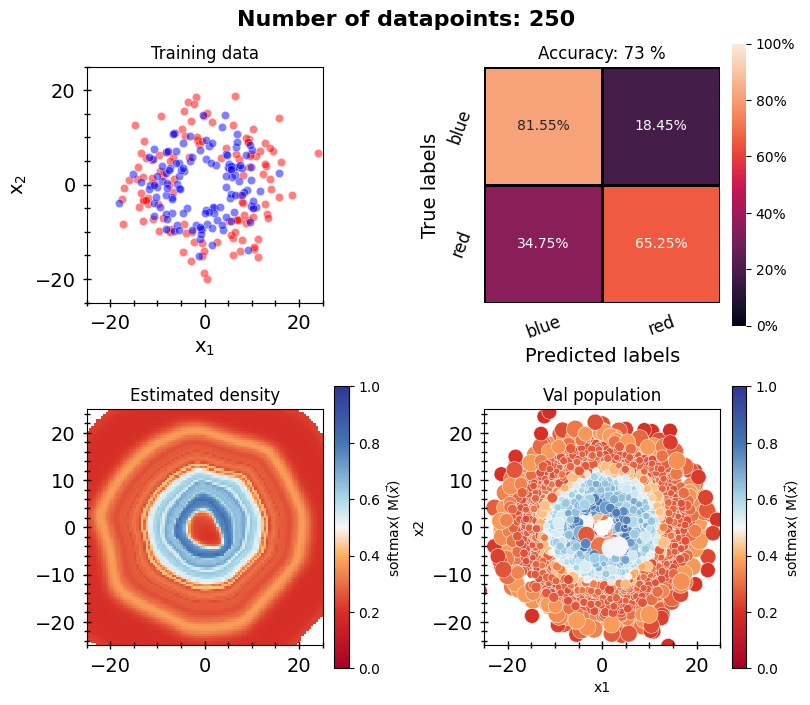

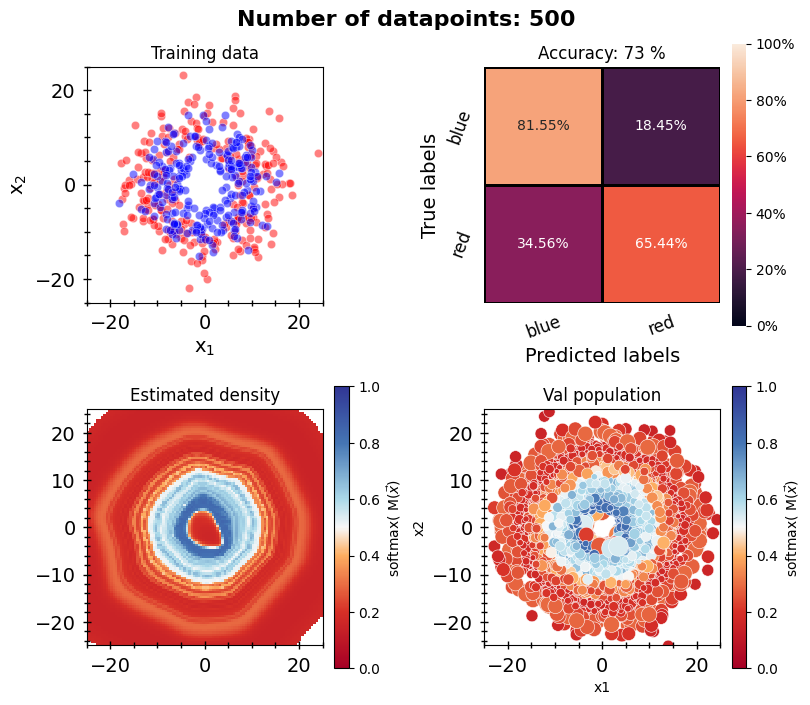

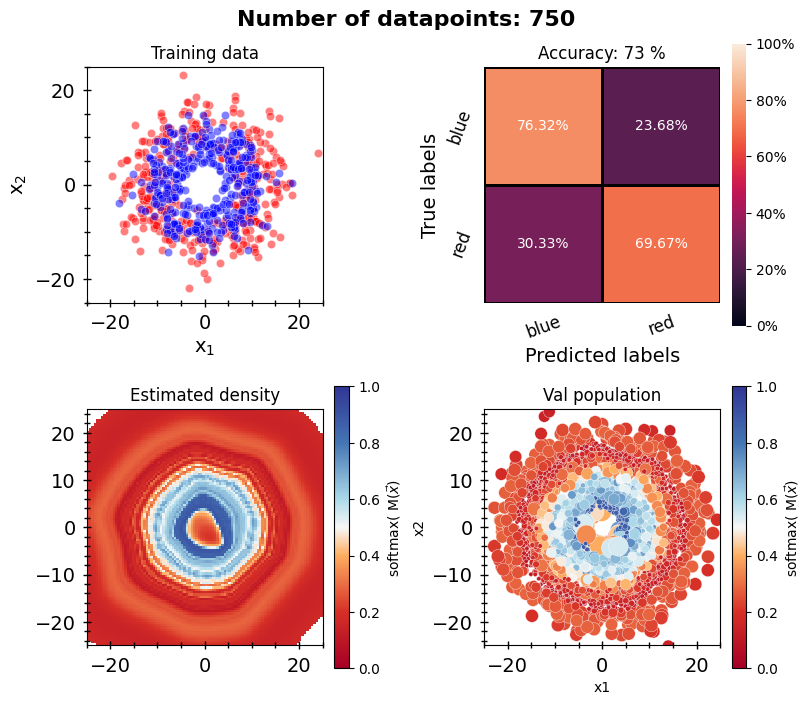

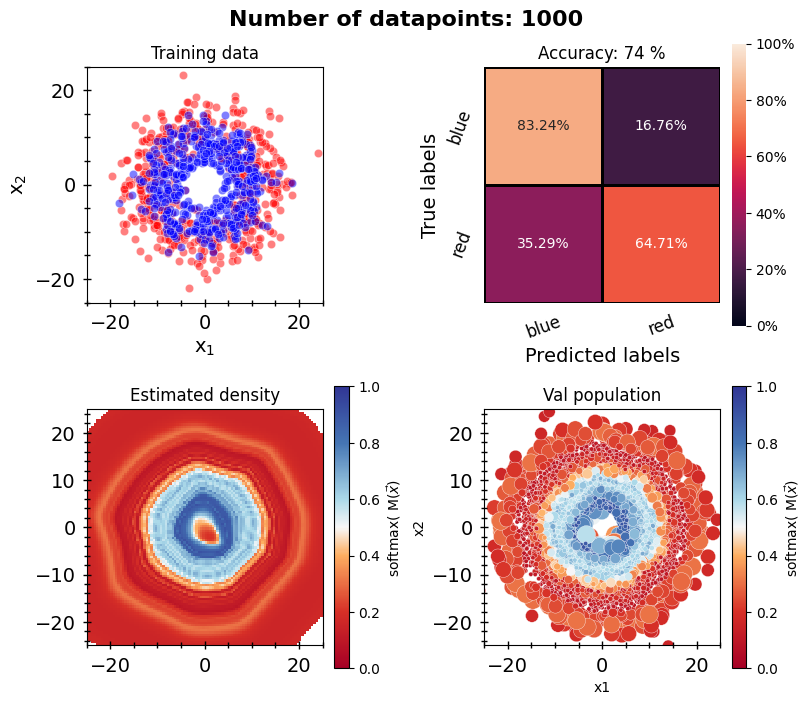

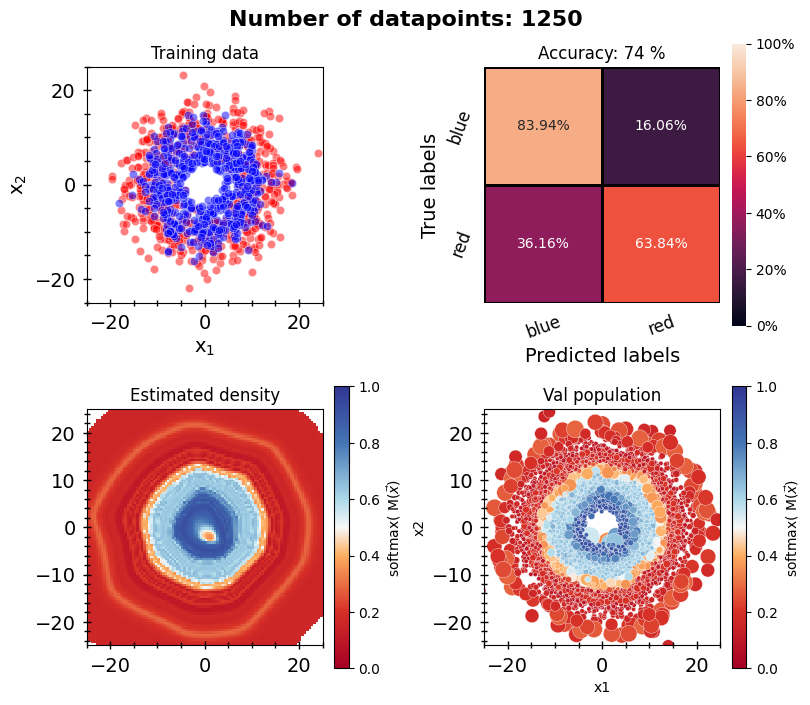

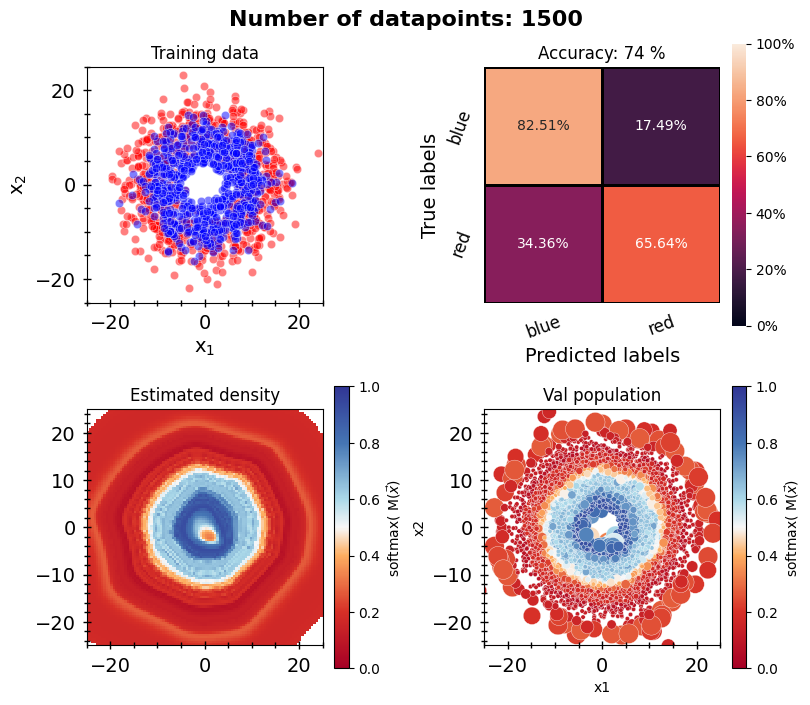

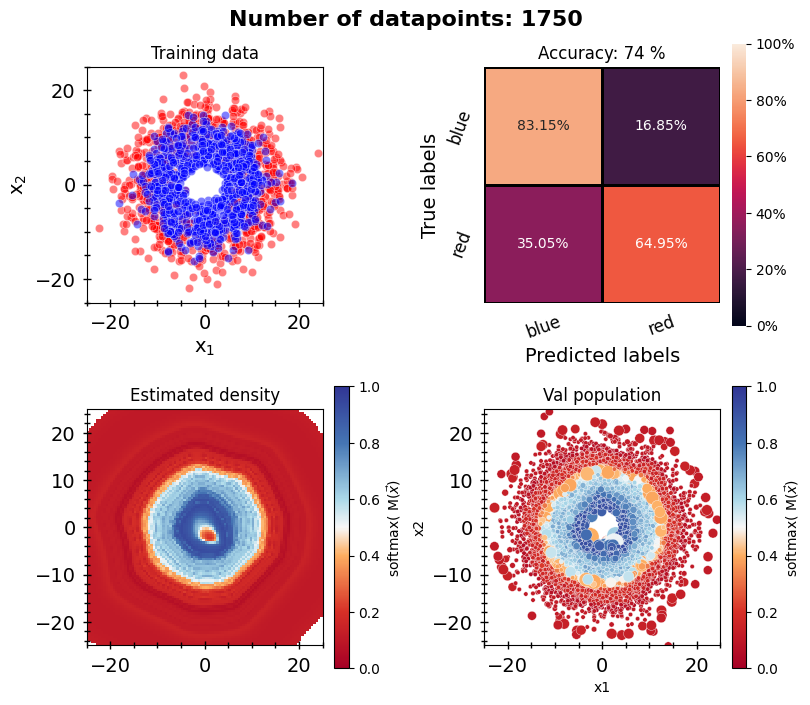

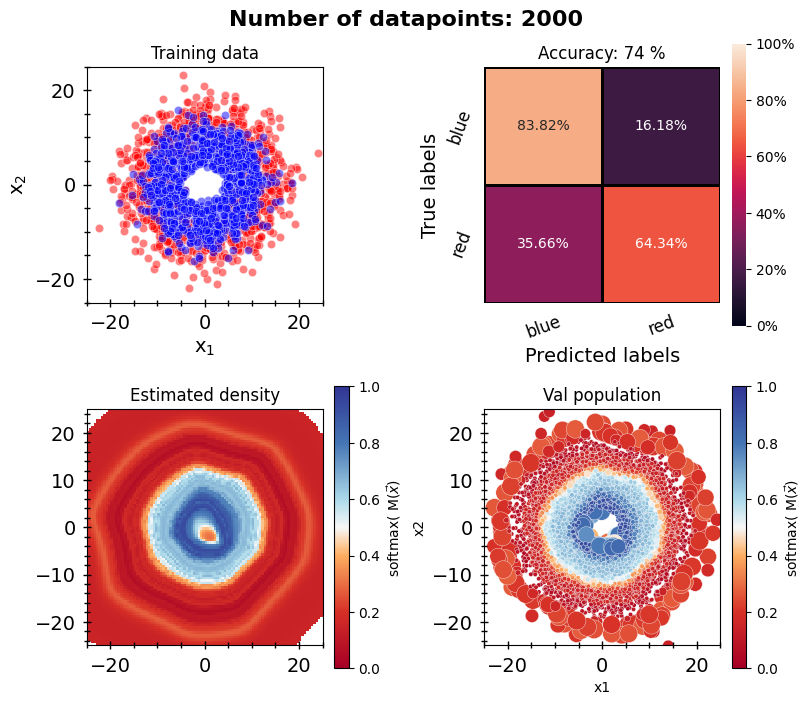

In [19]:

for i in range(n_plots):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
    #plot data
    axs[0][0] = plot_data(cal_data[0:n_cal[i]], axs[0][0], "Training data")
    axs[0][1] = plot_conf_matrix(test_dfs[i], "Truth", "Inferred_color", ["blue", "red"], axs[0][1])
    axs[1][0] = plot_results(grid_dfs[i], weight_key, axs[1][0], "Estimated density", grid=True)
    axs[1][1] = plot_results(test_dfs[i], weight_key, axs[1][1], "Val population")
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

    fig.suptitle(f"Number of calibration datapoints: {n_cal[i]}", size=16, fontweight="bold")

#plt.show()
    

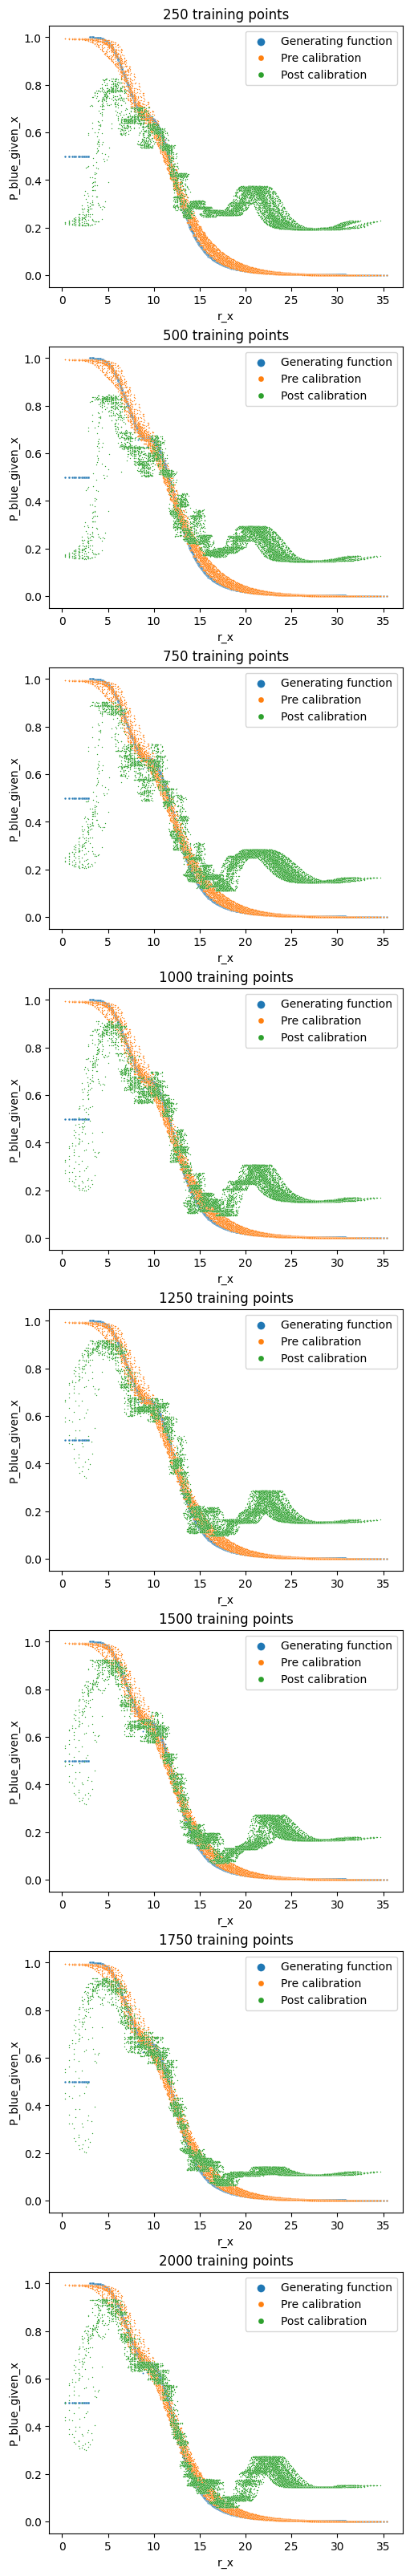

In [14]:
fig, axs = plt.subplots(nrows=len(n_cal), ncols=1, figsize= (5, 4*len(n_cal)), layout="constrained")
for i in range(len(n_cal)):
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[i], label="Generating function")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Confidence", s=1, ax = axs[i], label = "Pre calibration")
    sn.scatterplot(grid_dfs[i], x="r_x", y="P(blue|x)", s=1, ax = axs[i], label = "Post calibration")
    axs[i].set_title(f"{n_cal[i]} training points")
    axs[i].legend(markerscale=5)


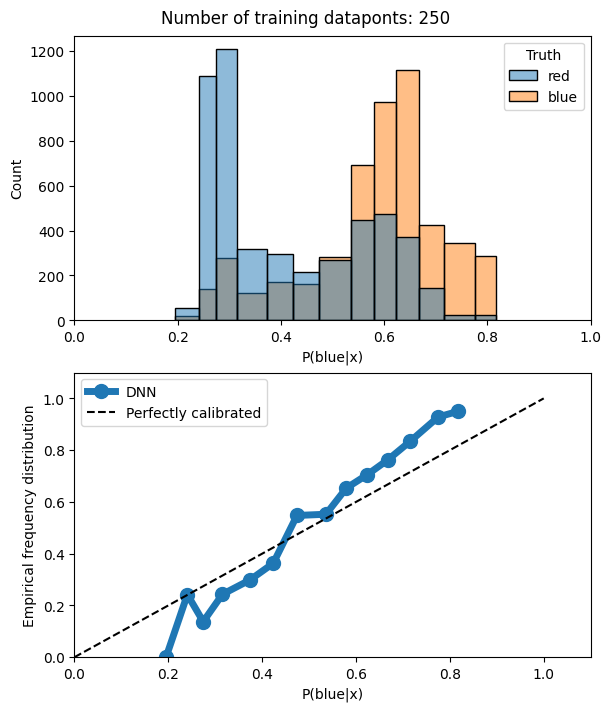

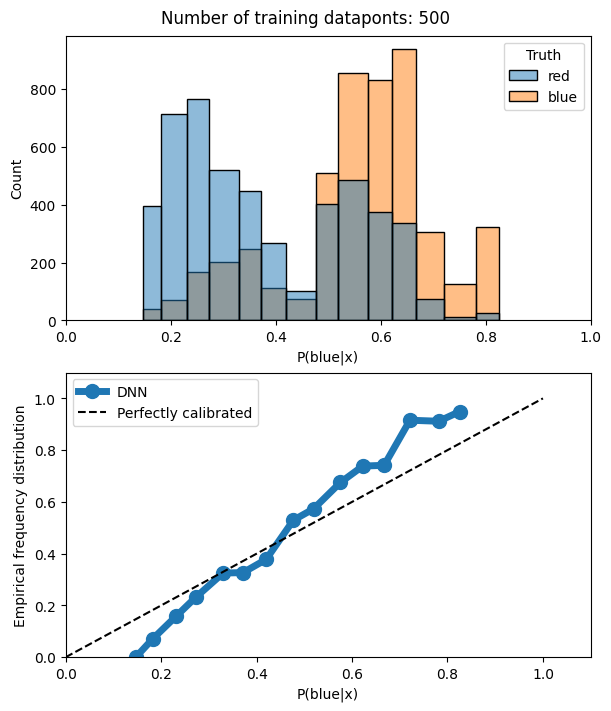

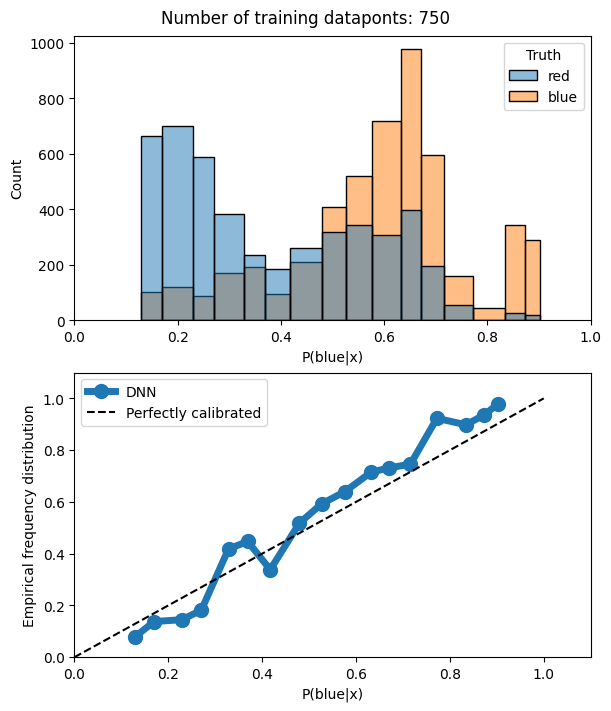

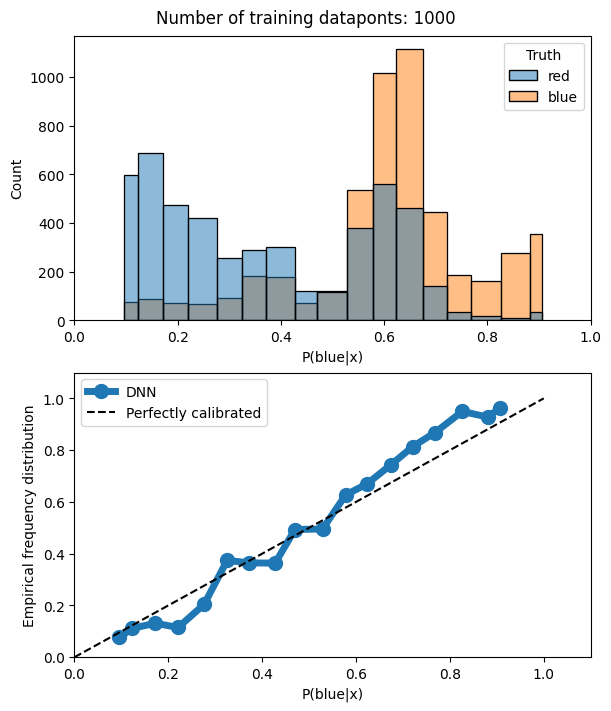

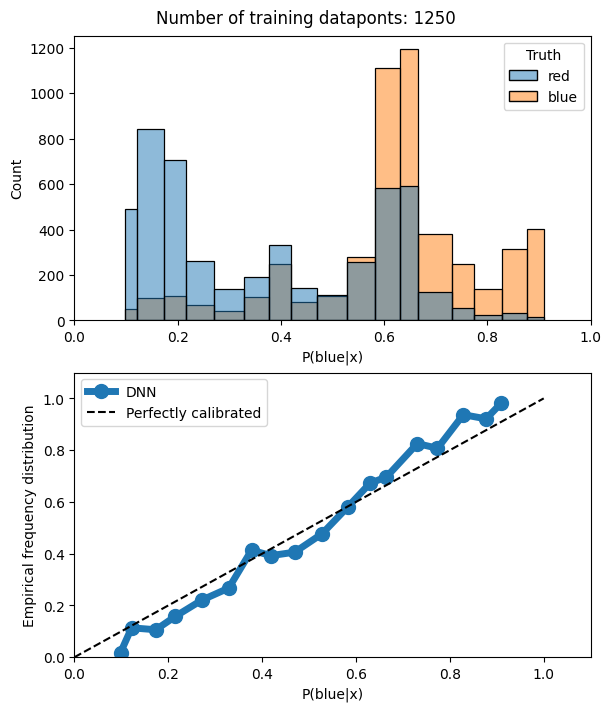

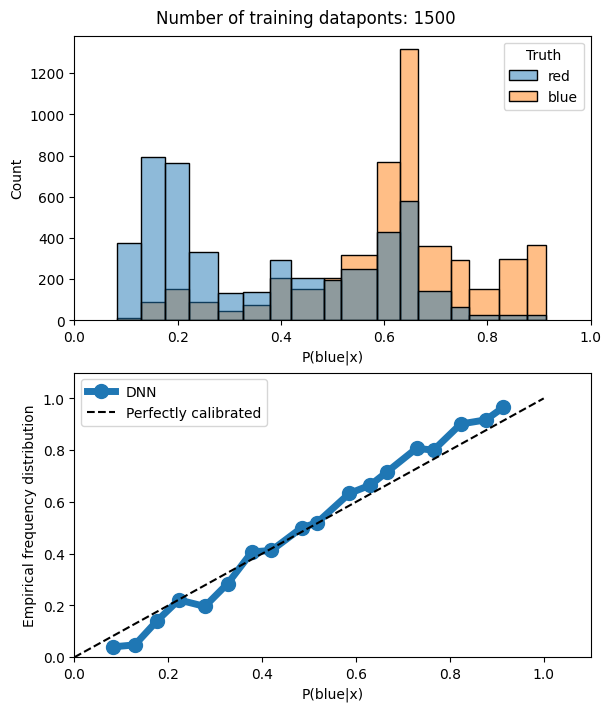

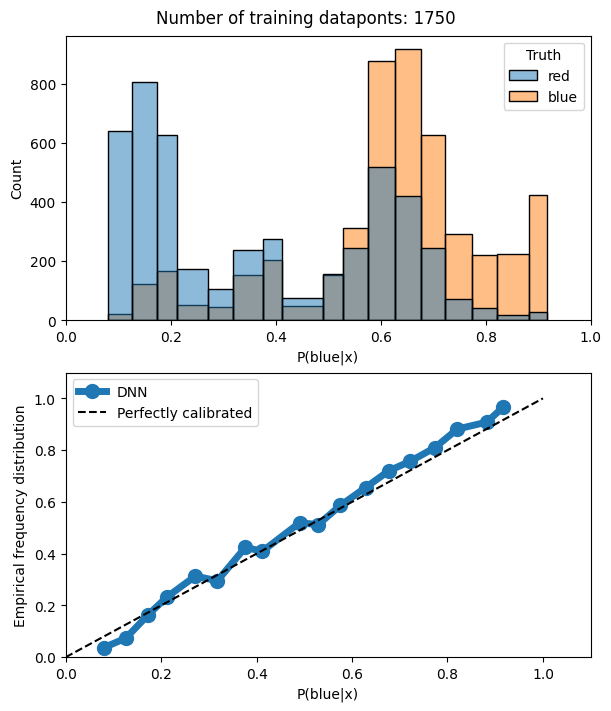

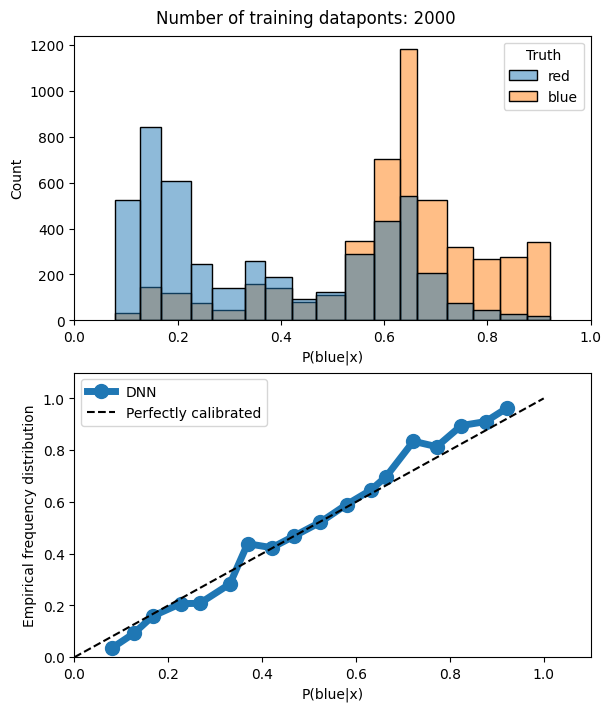

In [15]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

for i in range(len(n_cal)):
    #Get confidence for red
    prob_cal, prob_pred = calibration_curve(test_dfs[i]["Truth_value"], test_dfs[i]["P(blue|x)"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), layout="constrained")
    sn.histplot(test_dfs[i], x="P(blue|x)", hue="Truth", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("P(blue|x)")
    ax[1].set_ylabel("Empirical frequency distribution")
    ax[1].legend()
    fig.suptitle(f"Number of training dataponts: {n_cal[i]}")

Text(0, 0.5, 'Probability')

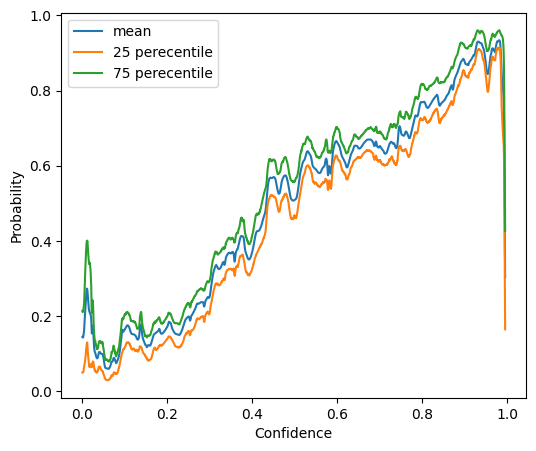

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
sn.lineplot(test_dfs[-1], x="Confidence", y="blue", label="mean", ax=ax)
sn.lineplot(test_dfs[-1], x="Confidence", y="quantile25_blue", label = "25 perecentile", ax=ax)
sn.lineplot(test_dfs[-1], x="Confidence", y="quantile75_blue", label = "75 perecentile", ax=ax)
ax.legend()
ax.set_ylabel("Probability")